### Combining it all together

This cookbook shows how to visualize the Layerwise Relevance Propogation data that was generated to determine the importance of given features to the AQI classification. 

In [1]:
import glob
import sys
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import xarray as xr
import pandas as pd
import numpy as np

/home/rjackson/.conda/envs/pydda_env/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


Query local directories for all of the input RLP data.

In [5]:
from datetime import timedelta
pickles = '/lcrc/group/earthscience/rjackson/opencrums/scripts/relevance_pickles/'
out_plot_path = '/lcrc/group/earthscience/rjackson/merra_relevances/'
hour = 0
pickle_list = glob.glob(pickles + 'rel-%dhr*.pickle' % hour)
code = 'HOU'
if code == 'HOU':
    ax_extent = [-105, -85, 25, 35]
elif code == 'SEUS':
    ax_extent = [-90, -75, 30, 37.5]

Load a copy of the MERRA2 data to get the base lat/lon grid.

In [6]:
# Get lats, lons for plotting
ds = xr.open_mfdataset(
            '/lcrc/group/earthscience/rjackson/MERRA2/hou_reduced/DUCMASS*.nc')
print(ds.time)
x = ds["DUCMASS"].values
lon = ds["lon"].values
lat = ds["lat"].values
lon_inds = np.argwhere(
            np.logical_and(
                ds.lon.values >= ax_extent[0],
                ds.lon.values <= ax_extent[1])).astype(int)
lat_inds = np.argwhere(
            np.logical_and(
                ds.lat.values >= ax_extent[2],
                ds.lat.values <= ax_extent[3])).astype(int)
lon = lon[lon_inds]
lat = lat[lat_inds]

time = ds["time"].values
ds.close()

<xarray.DataArray 'time' (time: 90744)>
array(['2010-01-01T00:30:00.000000000', '2010-01-01T01:30:00.000000000',
       '2010-01-01T02:30:00.000000000', ..., '2020-05-08T21:30:00.000000000',
       '2020-05-08T22:30:00.000000000', '2020-05-08T23:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01T00:30:00 ... 2020-05-08T23:30:00
Attributes:
    long_name:       time
    time_increment:  10000
    begin_date:      20100101
    begin_time:      3000
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]


Calculate the normalized relevance for each time period. The normalized relevance here simply scales each of the input relevances from 0 to 1, where 0 is the minimum value of relevance for the time period and 1 is the maximum relevance.

In [19]:
classification = ['Good', 'Moderate', 'Unhealthy Sens.', 'Unhealthy', 'Hazardous']
mean_relevances = {}
p = open(pickle_list[0], mode="rb")
relevances = pickle.load(p)
num_points = np.zeros(5)
input_keys = []

for key in relevances.keys():
    if "input_" in key:
        input_keys.append(key)
        mean_relevances[key] = np.zeros((5, lat.shape[0], lon.shape[0]))

for picks in pickle_list:
    p = open(picks, mode='rb')
    relevances = pickle.load(p)
    classes = relevances['output'].numpy().argmax(axis=1)
    aqi = relevances['aqi'].argmax(axis=1)
    for k in input_keys:
        relevances[k] = relevances[k].numpy()

    
    for j in range(len(classes)):
        for k in input_keys:
            r_min = relevances[k][j, :, :].min()
            r_max = relevances[k][j, :, :].max()
            relevances[k][j, :, :] = (relevances[k][j, :, :] - r_min) / (r_max - r_min)
          
    for j in range(len(classes)):
        sum_all_r = np.squeeze(np.max(np.concatenate(
            [relevances[k][j, :, :] for k in input_keys])))
        num_points[classes[j]] = num_points[classes[j]] + 1 
        for k in input_keys:
            mean_relevances[k][classes[j], :, :] += np.squeeze(
                relevances[k][j, :, :]) 
            
    p.close()

Generate the dataset-wide averages of normalized relevance. Here, relevances near 0 should be interpreted as not relevant, 0.5 as no preference, and 1 as very relevant.

In [20]:
r_max = -np.inf
r_mean = 0
i = 0
for j in range(5):
    for k in input_keys:
        mean_relevances[k][j,:,:] /= num_points[j]
        r_max = np.max([r_max, np.percentile(mean_relevances[k][j, :, :], 95)])
        r_mean += np.mean(mean_relevances[k][j, :, :])
        i += 1
r_mean = r_mean / i

Use Cartopy to generate the plots of relevance over the Houston domain. In this example, we look at the relevance of dimethyl sulfide (DMS) to the AQI classification. It is evident that as conditions become more unhealthy that DMS over the Gulf becomes more relevant to the classification. Given the coastal location of Houston, this could be attributable to DMS enhancement of anthropogenic sulfate emission over Houston (Zhao et al. 2020).

### References 
Zhao J, Sarwar G, Gantt B, Foley K, Henderson BH, Pye HOT, Fahey K, Kang D, Mathur R, Zhang Y, Li Q, Saiz-Lopez A. Impact of dimethylsulfide chemistry on air quality over the Northern Hemisphere. Atmos Environ (1994). 2020 Oct 29;244:117961. doi: 10.1016/j.atmosenv.2020.117961. PMID: 33132736; PMCID: PMC7592702.

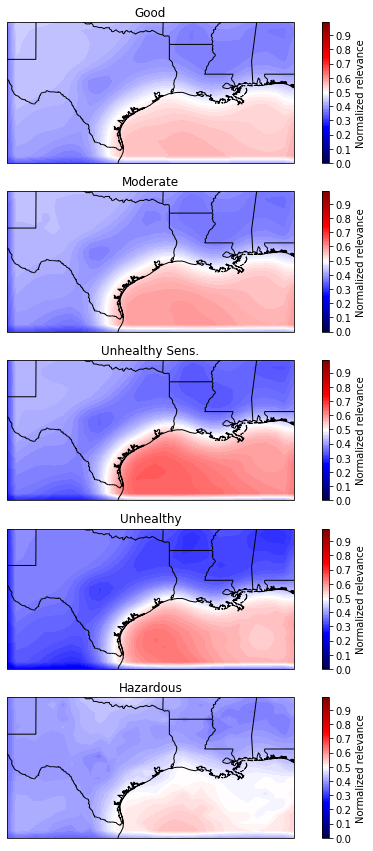

In [28]:
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

key = "input_DMSMASS"
fig, ax = plt.subplots(5, 1, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(10, 15))
x, y = np.meshgrid(lon, lat)
for l in range(1, 6):     
    r = np.squeeze(mean_relevances[key][l - 1])

    c = ax[l - 1].contourf(x, y, r,
        cmap='seismic', levels=np.arange(0, 1., 0.01))
    bar = plt.colorbar(c, label='Normalized relevance',
            ax=ax[l - 1])

    ax[l - 1].coastlines()
    ax[l - 1].add_feature(states_provinces)
    ax[l - 1].add_feature(cfeature.BORDERS)
    ax[l - 1].set_title(classification[l-1])
    ax[l - 1].set_xlabel('Latitude')
    ax[l - 1].set_ylabel('Longitude')